# Statistical Physics-Inspired Approach to Medical Diagnostics

## Disclaimer
This notebook presents a simple implementation of a statistical physics-inspired approach to medical diagnostics. Please note that this is a hypothetical scenario, and the model presented here may contain errors or oversimplifications. The goal is to explore how statistical mechanics concepts can be applied to medical diagnostics and improve understanding of disease-symptom relationships. This work is not intended for real-world medical use without further refinement and validation.

## Overview
This notebook explores a statistical mechanics-based probabilistic inference approach for medical diagnostics. Inspired by the work of Ramezanpour et al. (2020) and Mashaghi & Ramezanpour (2018), we model disease diagnosis as an inference problem, where observed symptoms provide clues about underlying conditions.

Traditional diagnostic models often assume symptoms are independent given a disease, but real-world conditions involve complex interactions between signs and diseases. Here, we integrate ideas from statistical physics (such as the Ising model) to better capture these dependencies.

## Objective
We aim to:

- Generate synthetic diagnostic data based on a probabilistic disease-symptom relationship.
- Estimate the joint probability distribution \( P(S, D) \) of signs \( S \) and diseases \( D \), mimicking real-world data.
- Infer the most probable disease(s) given a set of observed symptoms by computing the posterior distribution \( P(D | S) \).
- Optimize test selection to improve diagnostic accuracy with minimal tests, leveraging statistical physics concepts like Gibbs energy and mean-field approximations.
- Compare an optimized strategy against a random test selection approach.

## Approach

### Synthetic Data Generation:
We create randomized patient data, where diseases and their associated symptoms follow predefined probabilistic relationships. This dataset allows us to estimate the true underlying probability distribution \( P(S, D) \), similar to how real medical data is structured.

### Probabilistic Inference Model:
Given observed symptoms \( S \), we compute the posterior probability of each disease using \( P(D | S) \). The model incorporates pairwise symptom interactions and disease priors to improve prediction accuracy.

### Test Selection Strategies:
- **Optimized Test Selection**: Chooses the most informative test at each step, reducing diagnostic uncertainty.
- **Random Test Selection**: Selects tests randomly for comparison.

### Evaluation:
We assess both strategies based on:
- **Accuracy**: How well the model predicts diseases.
- **Efficiency**: How many tests are needed for a confident diagnosis.

## Key Components in the Code
- **Synthetic Data Generation**: Simulates patient disease and symptom relationships.
- **Inference Function**: Uses statistical mechanics-inspired methods to infer diseases from symptoms, approximating real-world probability distributions.
- **Test Selection**: Implements an entropy-based selection to prioritize informative tests.
- **Evaluation**: Compares optimized and random strategies based on accuracy and efficiency.

By applying concepts from statistical physics and AI, this approach improves disease diagnosis by dynamically adjusting to patient data, efficiently reducing uncertainty, and refining predictions over time.


In [ ]:
import numpy as np
import itertools
from tqdm import tqdm

# Data generation
def get_random_data(diseases, signs, disease_sign_weights, num_samples=500, random_state=42):
    np.random.seed(random_state)
    X = []
    y = []
    n_signs = len(signs)
    h_disease = np.zeros((n_signs, len(diseases)))
    for (d, s), w in disease_sign_weights.items():
        d_idx = diseases.index(d)
        s_idx = signs.index(s)
        h_disease[s_idx, d_idx] = np.log(w / (1 - w)) / 10
    for _ in range(num_samples):
        D = np.random.randint(0, 2, len(diseases))
        y.append(D)
        h = np.dot(h_disease, D)
        probs = 1 / (1 + np.exp(-h))
        S = np.where(np.random.random(n_signs) < probs, 1, -1)
        X.append(S)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Inference function
def predict_disease(S, observed_indices, h_base, h_disease, h_inter, disease_test_sign_weights, prior=None):
    n_diseases = len(diseases)
    n_total = len(signs + test_signs_)
    if prior is None:
        prior = np.ones(2**n_diseases) / 2**n_diseases
    D_configs = np.array(list(itertools.product([0, 1], repeat=n_diseases)))
    log_probs = []
    h_test = np.zeros((len(test_signs_), n_diseases))
    for (d, ts), w in disease_test_sign_weights.items():
        d_idx = diseases.index(d)
        ts_idx = test_signs_.index(ts)
        h_test[ts_idx, d_idx] = np.log(w / (1 - w)) / 10
    h_base_full = np.concatenate([h_base, np.zeros(len(test_signs_))])
    h_disease_full = np.vstack([h_disease, h_test])
    h_inter_full = np.vstack([h_inter, np.zeros((len(test_signs_), 3))])
    for D in D_configs:
        pairwise = np.array([D[0]*D[1], D[0]*D[2], D[1]*D[2]])
        h = h_base_full + np.dot(h_disease_full, D) + np.dot(h_inter_full, pairwise)
        energy = np.dot(h[observed_indices], S[observed_indices])
        unobserved = [i for i in range(n_total) if i not in observed_indices]
        Z = sum(np.exp(np.dot(h[unobserved], s)) for s in itertools.product([-1, 1], repeat=len(unobserved))) if unobserved else 1
        log_probs.append(energy - np.log(Z) + np.log(prior[np.where((D_configs == D).all(axis=1))[0][0]]))
    probs = np.exp(log_probs - np.max(log_probs))
    probs /= probs.sum()
    return D_configs, probs

# Optimized test selection
def select_next_test(S_observed, observed_indices, test_indices, h_base, h_disease, h_inter, disease_test_sign_weights, w=None):
    if w is None:
        w = np.ones(len(diseases))
    n_total = len(signs + test_signs_)
    S_current = np.zeros(n_total)
    S_current[observed_indices] = S_observed
    D_configs, P_D_given_S = predict_disease(S_current, observed_indices, h_base, h_disease, h_inter, disease_test_sign_weights)
    best_test = None
    best_EO = -np.inf
    for test_idx in test_indices:
        if test_idx not in observed_indices:
            EO = 0
            for test_value in [-1, 1]:
                S_new = np.zeros(n_total)
                new_indices = observed_indices + [test_idx]
                S_new[observed_indices] = S_observed
                S_new[test_idx] = test_value
                D_configs, P_D_given_S_new = predict_disease(S_new, new_indices, h_base, h_disease, h_inter, disease_test_sign_weights)
                P_Da = np.array([P_D_given_S_new[D_configs[:, a] == 1].sum() for a in range(len(diseases))])
                EO += 0.5 * np.sum(w * np.abs(P_Da - 0.5))
            if EO > best_EO:
                best_EO = EO
                best_test = test_idx
    return best_test

# Random test selection
def select_next_test_random(observed_indices, test_indices):
    available_tests = [idx for idx in test_indices if idx not in observed_indices]
    if not available_tests:
        return None
    return np.random.choice(available_tests)

def fit_h_params_on_rand_data(model_info, num_samples=500, random_state=42, num_test_data=100):
    X_train, y_train = get_random_data(model_info['diseases'], model_info['signs'], model_info['disease_sign_weights'], num_samples=num_samples, random_state=random_state)
    X_test, y_test = X_train[-num_test_data:], y_train[-num_test_data:]

    params_ = {}
    data_ = {'X_train':X_train, 'y_train': y_train, 'X_test':X_test, 'y_test':y_test}

    # Fit h parameters #TODO change this to be dynamic for other model specifications (limited to 3 diseases)
    disease_configs = np.unique(y_train, axis=0)
    sign_means = {tuple(D): X_train[np.all(y_train == D, axis=1)].mean(axis=0) if np.all(y_train == D, axis=1).sum() > 0 else np.zeros(len(signs)) for D in disease_configs}
    h_values = {D: np.arctanh(np.clip(means, -1 + 1e-6, 1 - 1e-6)) / 10 for D, means in sign_means.items()}
    X_reg = np.array([list(D) for D in h_values.keys()])
    y_reg = np.array([h for h in h_values.values()])
    pairwise_terms = [X_reg[:, 0] * X_reg[:, 1], X_reg[:, 0] * X_reg[:, 2], X_reg[:, 1] * X_reg[:, 2]]
    X_reg_extended = np.hstack([np.ones((X_reg.shape[0], 1)), X_reg, np.array(pairwise_terms).T])
    h_params = np.linalg.lstsq(X_reg_extended, y_reg, rcond=None)[0]
    params_['h_base'] = h_params[0]
    params_['h_disease'] = h_params[1:4].T 
    params_['h_inter'] = h_params[4:].T

    return data_, params_

# Evaluate with both strategies
def evaluate_strategy(model_info, select_func, label, threshold_main=0.5, threshold_step=0.06, max_tests=3, seed=42, num_samples=500, num_test_data=100):
    np.random.seed(seed)

    data_, params = fit_h_params_on_rand_data(model_info=model_info, num_samples=num_samples, num_test_data=num_test_data, random_state=seed)

    correct = 0
    total = len(data_['X_test'])
    initial_observed_indices = list(range(len(signs)))
    test_indices = list(range(len(signs), len(signs + test_signs_)))
    total_tests_used = 0

    for i in tqdm(range(total)):
        true_D = data_['y_test'][i]
        S_test_signs = np.zeros(len(test_signs_))
        for ts_idx, ts in enumerate(test_signs_):
            prob = 0
            for d_idx, d in enumerate(diseases):
                if true_D[d_idx] == 1 and (d, ts) in disease_test_sign_weights:
                    prob += disease_test_sign_weights[(d, ts)]
            prob = min(max(prob, 0), 1)
            S_test_signs[ts_idx] = 1 if np.random.random() < prob else -1
        S_test = np.concatenate([data_['X_test'][i], S_test_signs])
        
        S_observed = S_test[initial_observed_indices].copy()
        observed_indices = initial_observed_indices.copy()
        tests_used = 0
        
        D_configs, P_D_given_S = predict_disease(S_test, observed_indices, params['h_base'], params['h_disease'], params['h_inter'], disease_test_sign_weights)
        P_Da = np.array([P_D_given_S[D_configs[:, a] == 1].sum() for a in range(len(diseases))])
        polarization = np.max(np.abs(P_Da - 0.5))
        
        for step in range(max_tests):
            if polarization > threshold_main:
                break
            next_test_idx = select_func(S_observed, observed_indices, test_indices, params['h_base'], params['h_disease'], params['h_inter'], disease_test_sign_weights) if select_func == select_next_test else select_next_test_random(observed_indices, test_indices)
            if next_test_idx is None:
                break
            test_name = test_signs_[next_test_idx - len(signs)]
            test_value = S_test[next_test_idx]
            S_observed = np.append(S_observed, test_value)
            observed_indices.append(next_test_idx)
            tests_used += 1
            total_tests_used += 1
            D_configs, P_D_given_S = predict_disease(S_test, observed_indices, params['h_base'], params['h_disease'], params['h_inter'], disease_test_sign_weights)
            P_Da = np.array([P_D_given_S[D_configs[:, a] == 1].sum() for a in range(len(diseases))])
            polarization = np.max(np.abs(P_Da - 0.5))
            if polarization > threshold_step:
                break
        
        pred_D = D_configs[np.argmax(P_D_given_S)]
        if np.array_equal(pred_D, true_D):
            correct += 1
    
    accuracy = correct / total
    avg_tests_used = total_tests_used / total if total_tests_used > 0 else 0
    print(f"\n{label}:")
    print(f"Accuracy on test set: {accuracy:.4f} ({correct}/{total} correct)")
    print(f"Average tests used per sample: {avg_tests_used:.2f}")
    return accuracy, avg_tests_used

verbose = False

# Define diseases, signs, and test signs
diseases = ['D1', 'D2', 'D3']
signs = ['S1', 'S2', 'S3', 'S4', 'S5']
test_signs_ = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5']

disease_sign_weights = {
    ('D1', 'S1'): 0.8, ('D1', 'S2'): 0.6, ('D1', 'S3'): 0.5, ('D1', 'S5'): 0.8,
    ('D2', 'S1'): 0.7, ('D2', 'S2'): 0.5, ('D2', 'S3'): 0.9, ('D2', 'S5'): 0.6,
    ('D3', 'S1'): 0.3, ('D3', 'S3'): 0.6, ('D3', 'S4'): 0.8,
}
disease_test_sign_weights = {
    ('D1', 'TS1'): 0.7, ('D1', 'TS2'): 0.9, ('D2', 'TS3'): 0.8, ('D3', 'TS4'): 0.9, ('D1', 'TS5'): 0.6
}

model_info = {'diseases':diseases, 'signs':signs, 'disease_sign_weights': disease_sign_weights}

print("Running Optimized Strategy...")
opt_accuracy, opt_avg_tests = evaluate_strategy(model_info, select_next_test, "Optimized Strategy", seed=42)
print("Running Random Strategy...")
rand_accuracy, rand_avg_tests = evaluate_strategy(model_info, select_next_test_random, "Random Strategy", seed=42)

Running Optimized Strategy...


100%|██████████| 100/100 [00:03<00:00, 28.69it/s]



Optimized Strategy:
Accuracy on test set: 0.7800 (78/100 correct)
Average tests used per sample: 2.88
Running Random Strategy...


100%|██████████| 100/100 [00:00<00:00, 179.16it/s]


Random Strategy:
Accuracy on test set: 0.5200 (52/100 correct)
Average tests used per sample: 2.80


## Test Selection and Evaluation

In this section, we analyze a single sample from the synthetic data to evaluate the test selection process. The goal is to select the most informative tests based on their expected outcomes (EO values) and update the observed symptoms dynamically.

- **Initial Setup**: We generate synthetic data and select an initial set of observed symptoms.
- **Test Selection**: In each step, we calculate the Expected Outcome (EO) for each available test based on how it would affect disease probability predictions. The test with the highest EO is selected.
- **Disease Prediction**: After each test is selected, the model updates the observed symptoms and predicts the most probable disease using the current set of observations.
- **Heatmap Generation**: A heatmap is created to visualize how the EO values evolve across test selection steps, showing both the true and predicted disease states.

This process mimics a diagnostic procedure, where the model iteratively refines the disease predictions by selecting the most informative tests.

Analyzing single sample...
True Disease Configuration: [1. 0. 0.]
Initial Observed Signs: [-1. -1. -1.  1.  1.]
Step 1: Selected TS2 with value 1.0
Predicted Disease Probabilities: [0.55829708 0.49784141 0.48805972]
Step 2: Selected TS4 with value -1.0
Predicted Disease Probabilities: [0.55796382 0.49816513 0.43941281]
Step 3: Selected TS3 with value -1.0
Predicted Disease Probabilities: [0.5575214  0.46595514 0.43962401]


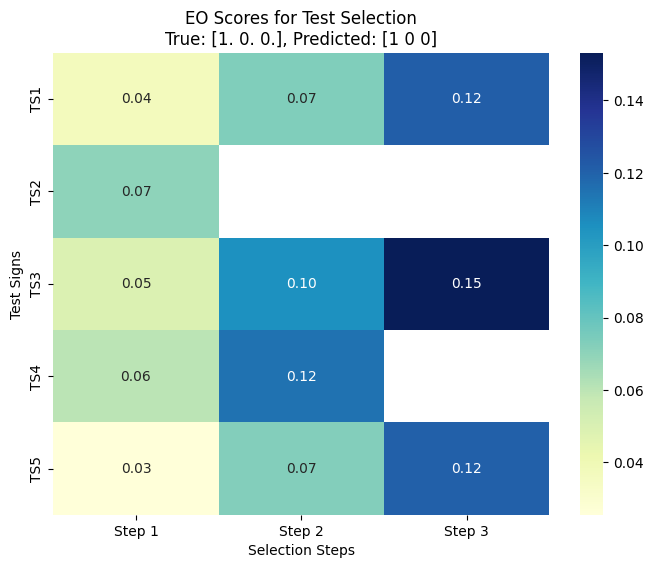

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Function to analyze one sample and collect EO over steps
def analyze_single_sample(model_info, sample_idx=0, max_tests=3, seed=42):
    np.random.seed(seed)
    data_, params = fit_h_params_on_rand_data(model_info=model_info, num_samples=500, num_test_data=100, random_state=seed)
    
    initial_observed_indices = list(range(len(signs)))
    test_indices = list(range(len(signs), len(signs + test_signs_)))
    
    # Get one sample
    true_D = data_['y_test'][sample_idx]
    S_test_signs = np.zeros(len(test_signs_))
    for ts_idx, ts in enumerate(test_signs_):
        prob = 0
        for d_idx, d in enumerate(diseases):
            if true_D[d_idx] == 1 and (d, ts) in disease_test_sign_weights:
                prob += disease_test_sign_weights[(d, ts)]
        prob = min(max(prob, 0), 1)
        S_test_signs[ts_idx] = 1 if np.random.random() < prob else -1
    S_test = np.concatenate([data_['X_test'][sample_idx], S_test_signs])
    
    S_observed = S_test[initial_observed_indices].copy()
    observed_indices = initial_observed_indices.copy()
    eo_matrix = []  # EO values for each test at each step
    
    print(f"True Disease Configuration: {true_D}")
    print(f"Initial Observed Signs: {S_observed}")
    
    # Step through test selection
    for step in range(max_tests):
        eo_values = np.zeros(len(test_signs_))  # EO for each test sign
        for test_idx in test_indices:
            if test_idx not in observed_indices:
                EO = 0
                ts_idx = test_idx - len(signs)
                for test_value in [-1, 1]:
                    S_new = np.zeros(len(signs + test_signs_))
                    new_indices = observed_indices + [test_idx]
                    S_new[observed_indices] = S_observed
                    S_new[test_idx] = test_value
                    D_configs, P_D_given_S_new = predict_disease(
                        S_new, new_indices, params['h_base'], params['h_disease'], 
                        params['h_inter'], disease_test_sign_weights
                    )
                    P_Da = np.array([P_D_given_S_new[D_configs[:, a] == 1].sum() for a in range(len(diseases))])
                    EO += 0.5 * np.sum(np.ones(len(diseases)) * np.abs(P_Da - 0.5))
                eo_values[ts_idx] = EO
            else:
                eo_values[test_idx - len(signs)] = np.nan  # Mark as unavailable
        eo_matrix.append(eo_values.copy())
        
        # Select next test
        next_test_idx = select_next_test(
            S_observed, observed_indices, test_indices, params['h_base'], 
            params['h_disease'], params['h_inter'], disease_test_sign_weights
        )
        if next_test_idx is None:
            break
        test_value = S_test[next_test_idx]
        test_name = test_signs_[next_test_idx - len(signs)]
        print(f"Step {step + 1}: Selected {test_name} with value {test_value}")
        S_observed = np.append(S_observed, test_value)
        observed_indices.append(next_test_idx)
        
        # Predict disease probabilities
        D_configs, P_D_given_S = predict_disease(
            S_test, observed_indices, params['h_base'], params['h_disease'], 
            params['h_inter'], disease_test_sign_weights
        )
        pred_D = D_configs[np.argmax(P_D_given_S)]
        P_Da = np.array([P_D_given_S[D_configs[:, a] == 1].sum() for a in range(len(diseases))])
        print(f"Predicted Disease Probabilities: {P_Da}")
    
    return np.array(eo_matrix), true_D, pred_D

# Generate heatmap
def plot_heatmap_single_sample(eo_matrix, test_signs, true_D, pred_D):
    plt.figure(figsize=(8, 6))
    sns.heatmap(eo_matrix.T, cmap="YlGnBu", annot=True, fmt=".2f", cbar=True,
                xticklabels=[f"Step {i+1}" for i in range(eo_matrix.shape[0])],
                yticklabels=test_signs, mask=np.isnan(eo_matrix.T))
    plt.title(f"EO Scores for Test Selection\nTrue: {true_D}, Predicted: {pred_D}")
    plt.xlabel("Selection Steps")
    plt.ylabel("Test Signs")
    plt.show()

# Define diseases, signs, and test signs
diseases = ['D1', 'D2', 'D3']
signs = ['S1', 'S2', 'S3', 'S4', 'S5']
test_signs_ = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5']

disease_sign_weights = {
    ('D1', 'S1'): 0.8, ('D1', 'S2'): 0.6, ('D1', 'S3'): 0.5, ('D1', 'S5'): 0.8,
    ('D2', 'S1'): 0.7, ('D2', 'S2'): 0.5, ('D2', 'S3'): 0.9, ('D2', 'S5'): 0.6,
    ('D3', 'S1'): 0.3, ('D3', 'S3'): 0.6, ('D3', 'S4'): 0.8,
}
disease_test_sign_weights = {
    ('D1', 'TS1'): 0.7, ('D1', 'TS2'): 0.9, ('D2', 'TS3'): 0.8, ('D3', 'TS4'): 0.9, ('D1', 'TS5'): 0.6
}

model_info = {'diseases': diseases, 'signs': signs, 'disease_sign_weights': disease_sign_weights}

print("Analyzing single sample...")
eo_matrix, true_D, pred_D = analyze_single_sample(model_info, sample_idx=2, max_tests=3, seed=1)

plot_heatmap_single_sample(eo_matrix, test_signs_, true_D, pred_D)

## Comparison of Test Selection Strategies

In this section, we compare the performance of two test selection strategies: **Optimized** and **Random**. The goal is to evaluate how accuracy changes with the number of tests allowed, using both strategies.

- **Optimized Strategy**: Chooses the most informative tests at each step, aiming to maximize diagnostic accuracy.
- **Random Strategy**: Selects tests randomly, serving as a baseline for comparison.

We plot accuracy against the maximum number of tests allowed, to understand how each strategy performs as more tests are made available.

100%|██████████| 100/100 [00:01<00:00, 58.23it/s]



Optimized (Max 1):
Accuracy on test set: 0.3000 (30/100 correct)
Average tests used per sample: 1.00


100%|██████████| 100/100 [00:00<00:00, 266.96it/s]



Random (Max 1):
Accuracy on test set: 0.2600 (26/100 correct)
Average tests used per sample: 1.00


100%|██████████| 100/100 [00:02<00:00, 40.49it/s]



Optimized (Max 2):
Accuracy on test set: 0.4900 (49/100 correct)
Average tests used per sample: 1.99


100%|██████████| 100/100 [00:00<00:00, 259.71it/s]



Random (Max 2):
Accuracy on test set: 0.3800 (38/100 correct)
Average tests used per sample: 1.97


100%|██████████| 100/100 [00:02<00:00, 35.42it/s]



Optimized (Max 3):
Accuracy on test set: 0.7800 (78/100 correct)
Average tests used per sample: 2.88


100%|██████████| 100/100 [00:00<00:00, 227.56it/s]



Random (Max 3):
Accuracy on test set: 0.5200 (52/100 correct)
Average tests used per sample: 2.80


100%|██████████| 100/100 [00:03<00:00, 32.85it/s]



Optimized (Max 4):
Accuracy on test set: 0.7800 (78/100 correct)
Average tests used per sample: 3.71


100%|██████████| 100/100 [00:00<00:00, 213.81it/s]



Random (Max 4):
Accuracy on test set: 0.5900 (59/100 correct)
Average tests used per sample: 3.42


100%|██████████| 100/100 [00:02<00:00, 33.53it/s]



Optimized (Max 5):
Accuracy on test set: 0.7800 (78/100 correct)
Average tests used per sample: 3.89


100%|██████████| 100/100 [00:00<00:00, 191.30it/s]



Random (Max 5):
Accuracy on test set: 0.6300 (63/100 correct)
Average tests used per sample: 3.81


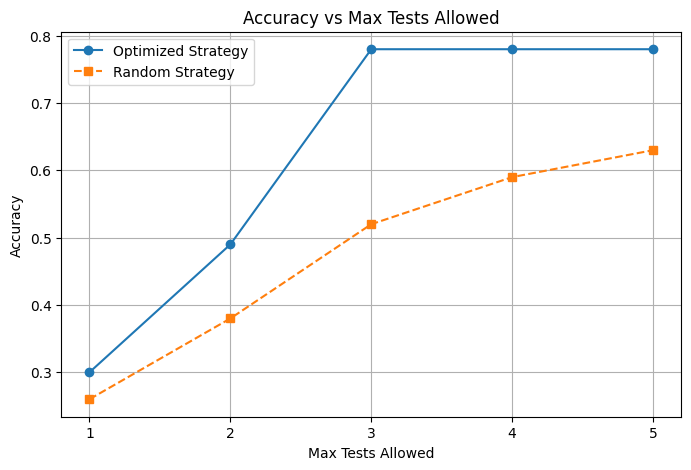

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate accuracy vs max tests allowed
def evaluate_max_tests(model_info, max_tests_range=list(range(1, 6)), threshold_step=0.06, seed=42):
    accuracies_opt = []
    accuracies_rand = []

    for max_tests in max_tests_range:
        opt_acc, _ = evaluate_strategy(model_info, select_next_test, f"Optimized (Max {max_tests})", max_tests=max_tests, threshold_step=threshold_step, seed=seed)
        rand_acc, _ = evaluate_strategy(model_info, select_next_test_random, f"Random (Max {max_tests})", max_tests=max_tests, threshold_step=threshold_step, seed=seed)
        accuracies_opt.append(opt_acc)
        accuracies_rand.append(rand_acc)

    return accuracies_opt, accuracies_rand

# Define range of max tests allowed
max_tests_range = list(range(1, 6))

# Run evaluations
accuracies_opt, accuracies_rand = evaluate_max_tests(model_info, max_tests_range)

plt.figure(figsize=(8, 5))
plt.plot(max_tests_range, accuracies_opt, label="Optimized Strategy", marker="o", linestyle="-")
plt.plot(max_tests_range, accuracies_rand, label="Random Strategy", marker="s", linestyle="--")
plt.xlabel("Max Tests Allowed")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Tests Allowed")
plt.xticks(list(range(1, 6)))
plt.legend()
plt.grid()
plt.show()


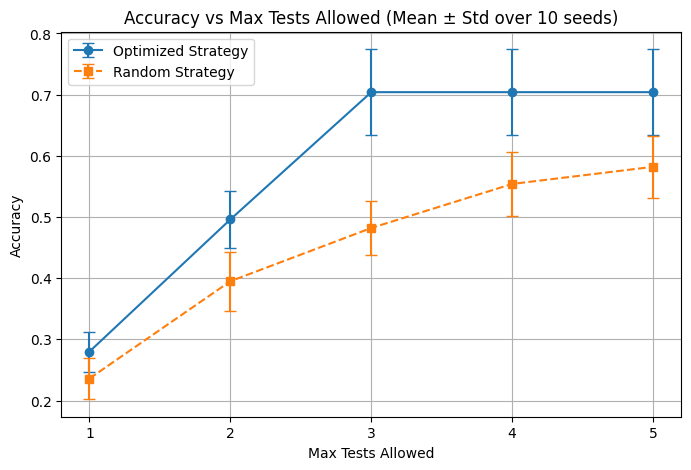

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to evaluate accuracy vs max tests allowed with multiple seeds
def evaluate_max_tests_seeds(max_tests_range, num_seeds=10, threshold_step=0.06):
    accuracies_opt = []
    accuracies_rand = []
    std_opt = []
    std_rand = []

    for max_tests in max_tests_range:
        opt_results = []
        rand_results = []

        for seed in range(num_seeds):
            np.random.seed(seed)
            opt_acc, _ = evaluate_strategy(model_info, select_next_test, f"Optimized (Max {max_tests})", max_tests=max_tests, threshold_step=threshold_step, seed=seed)
            rand_acc, _ = evaluate_strategy(model_info, select_next_test_random, f"Random (Max {max_tests})", max_tests=max_tests, threshold_step=threshold_step, seed=seed)
            opt_results.append(opt_acc)
            rand_results.append(rand_acc)

        # Compute mean and std for accuracy
        accuracies_opt.append(np.mean(opt_results))
        accuracies_rand.append(np.mean(rand_results))
        std_opt.append(np.std(opt_results))
        std_rand.append(np.std(rand_results))

    return accuracies_opt, std_opt, accuracies_rand, std_rand

# Define range of max tests allowed
max_tests_range = list(range(1, 6))

# Run evaluations with multiple seeds
accuracies_opt, std_opt, accuracies_rand, std_rand = evaluate_max_tests_seeds(max_tests_range)

# Plot accuracy vs max tests with error bars
plt.figure(figsize=(8, 5))
plt.errorbar(max_tests_range, accuracies_opt, yerr=std_opt, label="Optimized Strategy", marker="o", linestyle="-", capsize=4)
plt.errorbar(max_tests_range, accuracies_rand, yerr=std_rand, label="Random Strategy", marker="s", linestyle="--", capsize=4)
plt.xlabel("Max Tests Allowed")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Tests Allowed (Mean ± Std over 10 seeds)")
plt.xticks(list(range(1, 6)))
plt.legend()
plt.grid()
plt.show()


## Simple Comparison as Sanity Check using a MLP

In this section, we test a Multilayer Perceptron (MLP) to serve as a sanity check and evaluate how well a traditional machine learning model can perform the same diagnostic task. This comparison helps assess whether the performance of our probabilistic approach is competitive with a well-established machine learning technique

## Performance Comparison: Statistical Physics Model vs MLP

The accuracy results show an interesting trend: both the **Random** and **Optimized Statistical Physics Models** and the **MLP** start with similar performance in the range of **25-30% accuracy** when no tests are performed. As more tests are allowed, accuracy improves significantly.

- With **5 tests** allowed, both models (statistical physics and MLP) reach an accuracy around **75-80%** (for seed 42). 
- However, the **Statistical Physics Model** reaches it **with only 3 tests**, while the **MLP** is provided all 5 tests to reach this level of accuracy. This highlights the efficiency of the statistical physics model, which can achieve similar accuracy with fewer tests. 
- The statistical physics model also stops earlier based on the **confidence threshold**, which further supports its efficient decision-making process. 

Overall, the **Statistical Physics Model** provides comparable accuracy to the **MLP**, but with **fewer tests** and a more efficient use of available data, demonstrating its potential in diagnostic tasks with constrained resources.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

class MultiTaskMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultiTaskMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

def train_model(X_train, X_test, y_train, y_test, model, num_epochs=50, batch_size=32, lr=0.001, device='cuda'):

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

    criterion = nn.BCELoss()  
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).cpu()
        y_pred = (y_pred > 0.5).float()

    accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_pred.numpy())
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

data_, params = fit_h_params_on_rand_data(model_info=model_info, num_samples=500, num_test_data=100, random_state=42)

# Define model parameters
input_size = data_['X_train'].shape[1]
hidden_size = 64  
output_size = len(diseases)

model = MultiTaskMLP(input_size, hidden_size, output_size)

train_model(model=model, **data_, num_epochs=500)

Epoch [10/500], Loss: 0.6593
Epoch [20/500], Loss: 0.6371
Epoch [30/500], Loss: 0.6266
Epoch [40/500], Loss: 0.6199
Epoch [50/500], Loss: 0.6158
Epoch [60/500], Loss: 0.6128
Epoch [70/500], Loss: 0.6110
Epoch [80/500], Loss: 0.6090
Epoch [90/500], Loss: 0.6074
Epoch [100/500], Loss: 0.6059
Epoch [110/500], Loss: 0.6047
Epoch [120/500], Loss: 0.6038
Epoch [130/500], Loss: 0.6028
Epoch [140/500], Loss: 0.6020
Epoch [150/500], Loss: 0.6014
Epoch [160/500], Loss: 0.6009
Epoch [170/500], Loss: 0.6003
Epoch [180/500], Loss: 0.5999
Epoch [190/500], Loss: 0.5994
Epoch [200/500], Loss: 0.5991
Epoch [210/500], Loss: 0.5989
Epoch [220/500], Loss: 0.5988
Epoch [230/500], Loss: 0.5986
Epoch [240/500], Loss: 0.5984
Epoch [250/500], Loss: 0.5982
Epoch [260/500], Loss: 0.5983
Epoch [270/500], Loss: 0.5981
Epoch [280/500], Loss: 0.5981
Epoch [290/500], Loss: 0.5980
Epoch [300/500], Loss: 0.5979
Epoch [310/500], Loss: 0.5978
Epoch [320/500], Loss: 0.5978
Epoch [330/500], Loss: 0.5977
Epoch [340/500], Lo

In [ ]:
import numpy as np
import itertools
from tqdm import tqdm

def get_random_data(diseases, signs, test_signs_, disease_sign_weights, disease_test_sign_weights, num_samples=500, random_state=42):
    np.random.seed(random_state)
    X = []
    y = []
    n_signs = len(signs)
    n_test_signs = len(test_signs_)
    total_features = n_signs + n_test_signs
    
    # Compute h_disease matrix for signs
    h_disease = np.zeros((n_signs, len(diseases)))
    for (d, s), w in disease_sign_weights.items():
        d_idx = diseases.index(d)
        s_idx = signs.index(s)
        h_disease[s_idx, d_idx] = np.log(w / (1 - w)) / 10
    
    # Compute h_test matrix for test signs
    h_test = np.zeros((n_test_signs, len(diseases)))
    for (d, ts), w in disease_test_sign_weights.items():
        d_idx = diseases.index(d)
        ts_idx = test_signs_.index(ts)
        h_test[ts_idx, d_idx] = np.log(w / (1 - w)) / 10
    
    for _ in range(num_samples):
        D = np.random.randint(0, 2, len(diseases))
        y.append(D)
        
        # Compute probabilities for signs
        h_signs = np.dot(h_disease, D)
        probs_signs = 1 / (1 + np.exp(-h_signs))
        S_signs = np.where(np.random.random(n_signs) < probs_signs, 1, -1)
        
        # Compute probabilities for test signs
        h_test_signs = np.dot(h_test, D)
        probs_test_signs = 1 / (1 + np.exp(-h_test_signs))
        S_test_signs = np.where(np.random.random(n_test_signs) < probs_test_signs, 1, -1)
        
        # Combine signs and test signs into one feature vector
        S = np.concatenate([S_signs, S_test_signs])
        X.append(S)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def fit_h_params_on_rand_data(model_info, test_signs_, disease_test_sign_weights, num_samples=500, random_state=42, num_test_data=100):
    X_train, y_train = get_random_data(
        model_info['diseases'], 
        model_info['signs'], 
        test_signs_,  
        model_info['disease_sign_weights'], 
        disease_test_sign_weights, 
        num_samples=num_samples, 
        random_state=random_state
    )
    X_test, y_test = X_train[-num_test_data:], y_train[-num_test_data:]

    params_ = {}
    data_ = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}

    # Fit h parameters (limited to 3 diseases)
    disease_configs = np.unique(y_train, axis=0)
    # Since X_train now includes test signs, we only use the first len(signs) features for fitting
    sign_means = {
        tuple(D): X_train[np.all(y_train == D, axis=1), :len(model_info['signs'])].mean(axis=0) 
        if np.all(y_train == D, axis=1).sum() > 0 else np.zeros(len(model_info['signs'])) 
        for D in disease_configs
    }
    h_values = {D: np.arctanh(np.clip(means, -1 + 1e-6, 1 - 1e-6)) / 10 for D, means in sign_means.items()}
    X_reg = np.array([list(D) for D in h_values.keys()])
    y_reg = np.array([h for h in h_values.values()])
    pairwise_terms = [X_reg[:, 0] * X_reg[:, 1], X_reg[:, 0] * X_reg[:, 2], X_reg[:, 1] * X_reg[:, 2]]
    X_reg_extended = np.hstack([np.ones((X_reg.shape[0], 1)), X_reg, np.array(pairwise_terms).T])
    h_params = np.linalg.lstsq(X_reg_extended, y_reg, rcond=None)[0]
    params_['h_base'] = h_params[0]
    params_['h_disease'] = h_params[1:4].T 
    params_['h_inter'] = h_params[4:].T

    return data_, params_

# Define diseases, signs, and test signs
diseases = ['D1', 'D2', 'D3']
signs = ['S1', 'S2', 'S3', 'S4', 'S5']
test_signs_ = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5']

disease_sign_weights = {
    ('D1', 'S1'): 0.8, ('D1', 'S2'): 0.6, ('D1', 'S3'): 0.5, ('D1', 'S5'): 0.8,
    ('D2', 'S1'): 0.7, ('D2', 'S2'): 0.5, ('D2', 'S3'): 0.9, ('D2', 'S5'): 0.6,
    ('D3', 'S1'): 0.3, ('D3', 'S3'): 0.6, ('D3', 'S4'): 0.8,
}
disease_test_sign_weights = {
    ('D1', 'TS1'): 0.7, ('D1', 'TS2'): 0.9, ('D2', 'TS3'): 0.8, ('D3', 'TS4'): 0.9, ('D1', 'TS5'): 0.6
}

model_info = {'diseases': diseases, 'signs': signs, 'disease_sign_weights': disease_sign_weights}

# Generate data with all signs and test signs
data_, params = fit_h_params_on_rand_data(
    model_info=model_info, 
    test_signs_=test_signs_, 
    disease_test_sign_weights=disease_test_sign_weights,
    num_samples=500, 
    num_test_data=100, 
    random_state=42
)
X_full, y_full = get_random_data(
    diseases, 
    signs, 
    test_signs_, 
    disease_sign_weights, 
    disease_test_sign_weights, 
    num_samples=500, 
    random_state=42
)

# Define model parameters
input_size = X_full.shape[1]  # Total number of features (signs + test signs)
hidden_size = 64
output_size = len(diseases)

model = MultiTaskMLP(input_size, hidden_size, output_size)

# Train the model with the full dataset
train_model(model=model, X_train=X_full, y_train=y_full, X_test=data_['X_test'], y_test=data_['y_test'], num_epochs=500)

Epoch [10/500], Loss: 0.6376
Epoch [20/500], Loss: 0.5820
Epoch [30/500], Loss: 0.5226
Epoch [40/500], Loss: 0.4655
Epoch [50/500], Loss: 0.4171
Epoch [60/500], Loss: 0.3746
Epoch [70/500], Loss: 0.3364
Epoch [80/500], Loss: 0.3030
Epoch [90/500], Loss: 0.2763
Epoch [100/500], Loss: 0.2503
Epoch [110/500], Loss: 0.2284
Epoch [120/500], Loss: 0.2111
Epoch [130/500], Loss: 0.1959
Epoch [140/500], Loss: 0.1821
Epoch [150/500], Loss: 0.1707
Epoch [160/500], Loss: 0.1602
Epoch [170/500], Loss: 0.1504
Epoch [180/500], Loss: 0.1428
Epoch [190/500], Loss: 0.1376
Epoch [200/500], Loss: 0.1316
Epoch [210/500], Loss: 0.1283
Epoch [220/500], Loss: 0.1252
Epoch [230/500], Loss: 0.1219
Epoch [240/500], Loss: 0.1198
Epoch [250/500], Loss: 0.1182
Epoch [260/500], Loss: 0.1163
Epoch [270/500], Loss: 0.1149
Epoch [280/500], Loss: 0.1138
Epoch [290/500], Loss: 0.1126
Epoch [300/500], Loss: 0.1126
Epoch [310/500], Loss: 0.1114
Epoch [320/500], Loss: 0.1105
Epoch [330/500], Loss: 0.1101
Epoch [340/500], Lo